In [2]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [3]:
channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "data/SAROP11-CVME-PBPS2:Lnk9Ch12-DATA-SUM/data"            #Izero diode to Wavedream PBPS117 (Up - PDU)
channel_Izero2 = "data/SAROP11-CVME-PBPS2:Lnk9Ch13-DATA-SUM/data"           #Izero diode to Wavedream PBPS117 (Down - PDD)
channel_Izero3 = "data/SAROP11-CVME-PBPS2:Lnk9Ch14-DATA-SUM/data"           #Izero diode to Wavedream PBPS117 (Right - PDR)
channel_Izero4 = "data/SAROP11-CVME-PBPS2:Lnk9Ch15-DATA-SUM/data"           #Izero diode to Wavedream PBPS117 (Left - PDL)

channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
channel_LaserDiode_DIAG = "data/SLAAR11-LSCP1-FNS:CH4:VAL_GET/data"          #Laser diode on the DIAG table to laser Ioxos

channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)

channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"     #Huber stage Y position. 
channel_Events = "data/SAR-CVME-TIFALL5:EvtSet/data"

In [4]:
def LoadData_BS_noPumpProbe(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        
        FEL = BS_file[channel_Events][:,48]
        Laser = BS_file[channel_Events][:,18]
        Darkshot = BS_file[channel_Events][:,21]
        Jungfrau = BS_file[channel_Events][:,40]
        
        index_light = np.logical_and(Jungfrau,Laser,np.logical_not(Darkshot))
        
        Data = BS_file[channel_PIPS_trans][:][index_light]
        DataLaser = BS_file[channel_LaserDiode_DIAG][:][index_light]
        
        Izero = BS_file[channel_Izero][:][index_light]
        Position = BS_file[channel_position][:][index_light]
        
        PulseIDs = BS_file[channel_pulse_ids][:][index_light]
        
    return Data, DataLaser, Izero, Position, PulseIDs

In [9]:
def LoadData_BS_noPumpProbe(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = (pulse_ids%2 == 0)                                        #This is for 50 Hz
        reprate_laser = (pulse_ids%1 == 0)                                      #This is for 100 Hz
        
        Data = BS_file[channel_PIPS_trans][:][reprate_FEL]
        DataLaser = BS_file[channel_LaserDiode_DIAG][:][reprate_laser]
        
        Izero = BS_file[channel_Izero][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        
        PulseIDs = BS_file[channel_pulse_ids][:][reprate_laser]
        
    return Data, DataLaser, Izero, Position, PulseIDs

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*2*np.sqrt(np.log(2))/(np.abs(d)))

In [10]:
#filename = '/sf/alvra/data/p17806/raw/KR2_5uJLaser/run_000216.BSREAD.h5'
#filename = '/sf/alvra/data/p17807/raw/test_80_20_mode_50Hz_011.h5'

#filename = '/sf/alvra/data/p17807/raw/600_4uJ_70fs_MbCO_II/run_000497.BSREAD.h5'       # 600 fs / 4 uJ
#filename = '/sf/alvra/data/p17807/raw/light_4uJ_70fs_MbCO_II/run_000428.BSREAD.h5'     # 450 fs / 4 uJ

#filename = '/sf/alvra/data/p17807/raw/450_18uJ_70fs_MbCO_II/run_000455.BSREAD.h5'       # 450 fs / 18 uJ
#filename = '/sf/alvra/data/p17807/raw/600_18uJ_70fs_MbCO_II/run_000500.BSREAD.h5'       # 600 fs / 18 uJ

#filename = '/sf/alvra/data/p17807/raw/light_3uJ_70fs_MbCO_II/run_000337.BSREAD.h5'       # 10 ps / 3 uJ
#filename = '/sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000277.BSREAD.h5'       # 10 ps / 5 uJ

filename = '/sf/alvra/data/p17589/raw/test_V02/run_000026.BSREAD.h5' 

Data, DataLaser, Izero, Position, PulseIDs = LoadData_BS_noPumpProbe(filename)

In [11]:
DataLaser.shape

(19997, 1)

In [12]:
PulseIDs[0:10]

array([8593708884, 8593708885, 8593708886, 8593708887, 8593708888,
       8593708889, 8593708890, 8593708891, 8593708892, 8593708893])

<IPython.core.display.Javascript object>


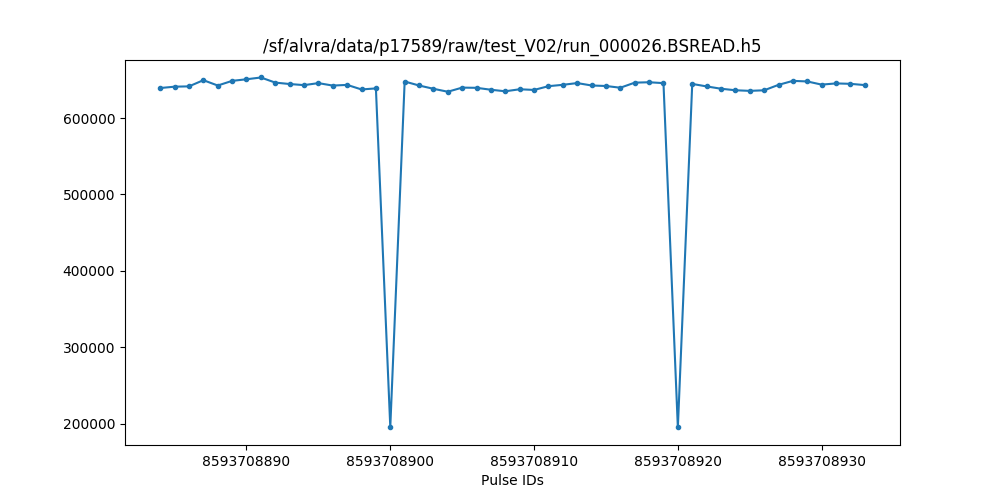

In [13]:
plt.figure(figsize= (10,5))

plt.plot(PulseIDs [0:50], DataLaser[0:50], marker='.')
plt.title(filename)
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel("Pulse IDs")
plt.show()

<IPython.core.display.Javascript object>


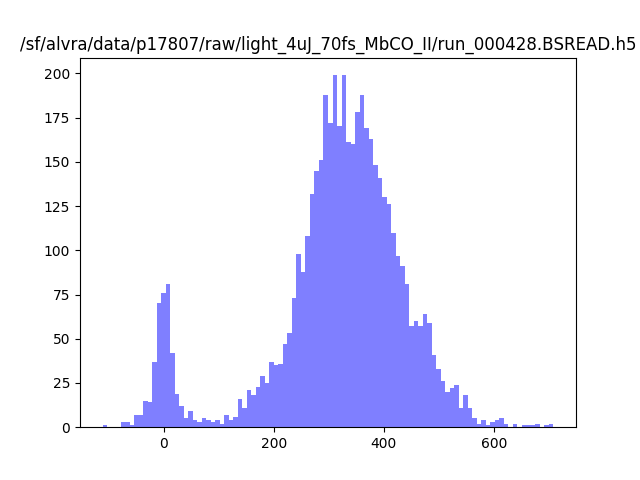

In [9]:
num_bins = 100

plt.figure()
plt.hist(DataLaser, num_bins, facecolor='blue', alpha=0.5)
#plt.hist(DataLaser_428, num_bins, facecolor='orange', alpha=0.5)

plt.title(filename)

plt.show()

In [10]:
#DIR = '/sf/alvra/data/p17807/raw/light_4uJ_70fs_MbCO_II/'   # 450 fs 4 uJ
#DIR = '/sf/alvra/data/p17807/raw/600_4uJ_70fs_MbCO_II/'     # 600 fs 4 uJ
#DIR = '/sf/alvra/data/p17807/raw/600_4uJ_repeated_70fs_MbCO_II/'     # 600 fs 4 uJ repeated

#DIR = '/sf/alvra/data/p17807/raw/450_18uJ_70fs_MbCO_II/'     # 450 fs 18 uJ
#DIR = '/sf/alvra/data/p17807/raw/600_18uJ_70fs_MbCO_II/'     # 600 fs 18 uJ

#DIR = '/sf/alvra/data/p17807/raw/light_3uJ_70fs_MbCO_II/'     # 10 ps 3 uJ
DIR = '/sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/'     # 10 ps 5 uJ
#DIR = '/sf/alvra/data/p17807/raw/light_10uJ_70fs_MbCO_II/'     # 10 ps 10 uJ
#DIR = '/sf/alvra/data/p17807/raw/light_18uJ_70fs_MbCO_II/'     # 10 ps 10 uJ



In [12]:
listfile = os.listdir(DIR)
number_files = len(listfile)

#start_index = 413     # 450 fs, 4 uJ
#start_index = 466      # 600 fs, 4 uJ
#start_index = 535      # 600 fs, 4 uJ repeated


#start_index = 440      # 450 fs, 18 uJ
#start_index = 498      # 600 fs, 18 uJ

#start_index = 323      # 10 ps, 3 uJ
start_index = 250      # 10 ps, 5 uJ
#start_index = 299      # 10 ps, 10 uJ
#start_index = 387      # 10 ps, 18 uJ

number_files = 50



all_runs = []



for i in range(start_index,start_index + number_files):
    fileName = DIR + "run_000" + str(i) + ".BSREAD.h5"
    # print (fileName)
    exists = os.path.isfile(fileName)
    if exists:
        print ("Processing file", fileName)
        Data, DataLaser, Izero, Position, PulseIDs = LoadData_BS_noPumpProbe(fileName)
               
        all_runs.append(DataLaser)
        
all_runs = np.asarray(all_runs)
print ("Job done!")

Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000250.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000251.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000252.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000253.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000254.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000255.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000256.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000257.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000258.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000259.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70fs_MbCO_II/run_000260.BSREAD.h5
Processing file /sf/alvra/data/p17807/raw/light_5uJ_70

In [13]:
all_runs.shape

(49, 5000, 1)

In [14]:
all_runs_1D = np.vstack(all_runs)
all_runs_1D.shape

(245000, 1)

In [15]:
all_runs_10ps_5uJ = all_runs_1D.copy()

<IPython.core.display.Javascript object>


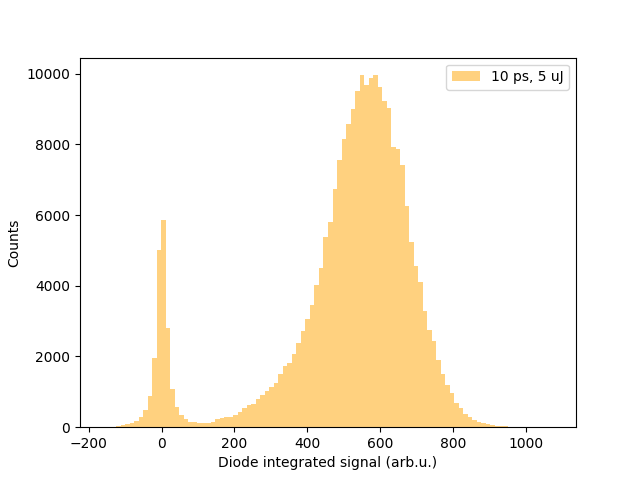

In [19]:
num_bins = 100

plt.figure()

#plt.hist(all_runs_450fs_4uJ, num_bins, facecolor='orange', label='450 fs, 4 uJ', alpha=0.5)
#plt.hist(all_runs_600fs_4uJ, num_bins, facecolor='blue',label='600 fs, 4 uJ', alpha=0.5)
#plt.hist(all_runs_600fs_4uJ_rep, num_bins, facecolor='green', label='600 fs, 4 uJ rep', alpha=0.5)


#plt.hist(all_runs_450fs_18uJ, num_bins, facecolor='orange', alpha=0.5)
#plt.hist(all_runs_600fs_18uJ, num_bins, facecolor='blue', alpha=0.5)

#plt.hist(all_runs_10ps_3uJ, num_bins, facecolor='black', label='10 ps, 3 uJ', alpha=0.5)
plt.hist(all_runs_10ps_5uJ, num_bins, facecolor='orange', label='10 ps, 5 uJ', alpha=0.5)
#plt.hist(all_runs_10ps_10uJ, num_bins, facecolor='green', label='10 ps, 10 uJ', alpha=0.5)
#plt.hist(all_runs_10ps_18uJ, num_bins, facecolor='black', label='10 ps, 18 uJ', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel ('Diode integrated signal (arb.u.)')
plt.ylabel ('Counts')
#plt.title(filename)

plt.show()